## Intrusive Galerkin

When talking about polynomial chaos expansions, there are typically two
categories methods that are used: non-intrusive and intrusive methods. The
distinction between the two categories lies in how one tries to solve the
problem at hand. In the intrusive methods, the core problem formulation,
often in the form of some governing equations to solve is reformulated to
target a polynomial chaos expansion. In the case of the non-intrusive methods
a solver for deterministic case is used in combination of some form of
collocation method to fit to the expansion.

The ``chaospy`` toolbox caters for the most part to the non-intrusive
methods. However it is still possible to use the toolbox to solve intrusive
formulation. It just requires that the user to do more of the mathematics
them selves.

### Problem revisited

This section uses the same example as the [problem
formulation](./problem_formulation.ipynb). To reiterate the problem
formulation:

$$
   \frac{d}{dt} u(t) = -\beta\ u(t) \qquad u(0) = \alpha \qquad t \in [0, 10]
$$

Here $\alpha$ is initial condition and $\beta$ is the exponential growth
rate. They are both unknown hyper parameters which can be described through a
joint probability distribution:

In [27]:
from ipynb.fs.full.problem_formulation import joint

joint

J(Normal(mu=1.5, sigma=0.2), Uniform(lower=0.1, upper=0.2))

Here the parameters are positional defined as $\alpha$ and $\beta$
respectively.

First step of intrusive Galerkin's method, we will first assume that the
solution $u(t)$ can be expressed as the sum:

$$
   u(t; \alpha, \beta) = \sum_{n=0}^N c_n(t)\ \Phi_n(\alpha, \beta)
$$

Here $\Phi_n$ are orthogonal polynomials and $c_n$ Fourier coefficients. We
do not know what the latter is yet, but the former we can construct from
distribution alone.

In [28]:
import chaospy

polynomial_expansion = chaospy.generate_expansion(3, joint)
polynomial_expansion[:4].round(10)

polynomial([1.0, q1-0.15, q0-1.5, q1**2-0.3*q1+0.0216666667])

Note again, that the variables are here defined positional. $\alpha$ and
$\beta$ corresponds to positions 0 and 1, which again corresponds to the
polynomial variables `q0` and `q1` respectively.

The second step of the method is to fill in the assumed solution into the
equations we are trying to solve the following two equations:

$$
   \frac{d}{dt} \sum_{n=0}^N c_n\ \Phi_n = -\beta \sum_{n=0}^N c_n \qquad
   \sum_{n=0}^N c_n(0)\ \Phi_n = \alpha
$$

The third step is to take the inner product of each side of both equations
against the polynomial $\Phi_k$ for $k=0,\cdots,N$. For the first equation,
this will have the following form:

$$
\begin{align*}
   \left\langle \frac{d}{dt} \sum_{n=0}^N c_n \Phi_n, \Phi_k \right\rangle &=
   \left\langle -\beta \sum_{n=0}^N c_n\Phi_n, \Phi_k \right\rangle \\
   \left\langle \sum_{n=0}^N c_n(0)\ \Phi_n, \Phi_k \right\rangle &=
   \left\langle \alpha, \Phi_k \right\rangle \\
\end{align*}
$$

Let us define the first equation as the main equation, and the latter as the
initial condition equation.

### Main equation

We start by simplifying the equation. A lot of collapsing of the sums is
possible because of the orthogonality property of the polynomials $\langle
\Phi_i, \Phi_j\rangle$ for $i \neq j$.

$$
\begin{align*}
   \left\langle \frac{d}{dt} \sum_{n=0}^N c_n \Phi_n, \Phi_k \right\rangle &=
   \left\langle -\beta \sum_{n=0}^N c_n\Phi_n, \Phi_k \right\rangle \\
   \sum_{n=0}^N \frac{d}{dt} c_n \left\langle \Phi_n, \Phi_k \right\rangle &=
   -\sum_{n=0}^N c_n \left\langle \beta\ \Phi_n, \Phi_n \right\rangle \\
      \frac{d}{dt} c_k \left\langle \Phi_k, \Phi_k \right\rangle &=
   -\sum_{n=0}^N c_n \left\langle \beta\ \Phi_n, \Phi_k \right\rangle \\
   \frac{d}{dt} c_k &=
   -\sum_{n=0}^N c_n
   \frac{
      \left\langle \beta\ \Phi_n, \Phi_k \right\rangle
   }{
      \left\langle \Phi_k, \Phi_k \right\rangle
   }
\end{align*}
$$

Or equivalent, using probability notation:

$$
   \frac{d}{dt} c_k =
   -\sum_{n=0}^N c_n
   \frac{
      \mbox E\left( \beta\ \Phi_n \Phi_k \right)
   }{
      \mbox E\left( \Phi_k \Phi_k \right)
   }
$$

This is a set of linear equations. To solve them in practice, we need to
formulate the right-hand-side as a function. To start we create variables to
deal with the fact that $\alpha$ and $\beta$ are part of the equation.

In [29]:
alpha, beta = chaospy.variable(2)

As above, these two variables are defined positional to correspond to both
the distribution and polynomial.

From the simplified equation above, it can be observed that the fraction of
expected values doesn't depend on neither $c$ nor $t$, and can therefore be
pre-computed.

For the denominator $\mathbb E[\beta\Phi_n\Phi_k]$, since there are both $\Phi_k$
and $\Phi_n$ terms, the full expression can be defined as a two-dimensional
tensor:

In [30]:
phi_phi = chaospy.outer(
    polynomial_expansion, polynomial_expansion)
[polynomial_expansion.shape, phi_phi.shape]

[(10,), (10, 10)]

This allows us to calculate the full expression:

In [31]:
e_beta_phi_phi = chaospy.E(beta*phi_phi, joint)
e_beta_phi_phi[:3, :3].round(6)

array([[1.50e-01, 8.33e-04, 0.00e+00],
       [8.33e-04, 1.25e-04, 0.00e+00],
       [0.00e+00, 0.00e+00, 6.00e-03]])

For the numerator $\mbox E(\Phi_k\Phi_k)$, it is worth noting that these are
the square of the norms $\|\Phi_k\|^2$. We could calculate them the same way,
but choose not to. Calculating the norms is often numerically unstable, and
it is better to retrieve them from three-terms-recursion process. In
``chaospy`` this can be extracted during the creation of the orthogonal
polynomials:

In [32]:
_, norms = chaospy.generate_expansion(3, joint, retall=True)
norms[:4].round(6)

array([1.00e+00, 8.33e-04, 4.00e-02, 1.00e-06])

Having all terms in place, we can create a function for the right-hand-side
of the equation:

In [33]:
import numpy

def right_hand_side(c, t):
    return -numpy.sum(c*e_beta_phi_phi, -1)/norms

### Initial conditions

The equation associated with the initial condition can be reformulated as
follows:

$$
\begin{align*}
   \left\langle \sum_{n=0}^N c_n(0)\ \Phi_n, \Phi_k \right\rangle &=
   \left\langle \alpha, \Phi_k \right\rangle \\
   \sum_{n=0}^N c_n(0) \left\langle \Phi_n, \Phi_k \right\rangle &=
   \left\langle \alpha, \Phi_k \right\rangle \\
   c_k(0) \left\langle \Phi_k, \Phi_k \right\rangle &=
   \left\langle \alpha, \Phi_k \right\rangle \\
   c_k(0) &=
   \frac{
      \left\langle \alpha, \Phi_k \right\rangle
   }{
      \left\langle \Phi_k, \Phi_k \right\rangle
   }
\end{align*}
$$

Or equivalently:

$$
   c_k(0) =
   \frac{
      \mbox E\left( \alpha\ \Phi_k \right)
   }{
      \mbox E\left( \Phi_k \Phi_k \right)
   }
$$

Using the same logic as for the first equation we get:

In [34]:
e_alpha_phi = chaospy.E(alpha*polynomial_expansion, joint)
initial_condition = e_alpha_phi/norms

### Equation solving

With the right-hand-side for both the main set of equations and the initial
conditions, it should be straight forward to solve the equations numerically.
For example using `scipy.integrate.odeint`:

In [35]:
from scipy.integrate import odeint

coordinates = numpy.linspace(0, 10, 1000)
coefficients = odeint(func=right_hand_side,
                      y0=initial_condition, t=coordinates)

coefficients.shape

(1000, 10)

These coefficients can then be used to construct the approximation for $u$
using the assumption about the solutions form:

In [36]:
u_approx = chaospy.sum(polynomial_expansion*coefficients, -1)
u_approx[:4].round(2)

polynomial([q0, -0.01*q0*q1+q0, -0.02*q0*q1+q0, -0.03*q0*q1+q0])

Finally, this can be used to calculate statistical properties:

In [37]:
mean = chaospy.E(u_approx, joint)
variance = chaospy.Var(u_approx, joint)

mean[:5].round(6), variance[:5].round(6)

(array([1.5     , 1.49775 , 1.495503, 1.493259, 1.491019]),
 array([0.04    , 0.03988 , 0.039761, 0.039643, 0.039525]))

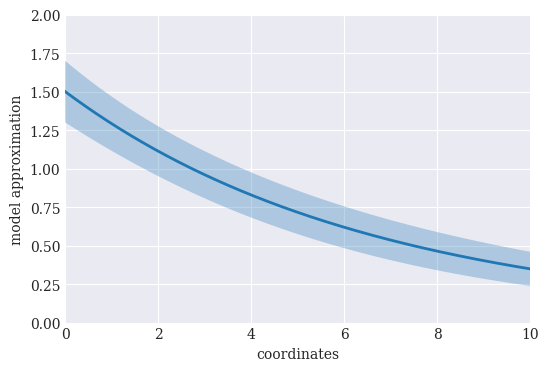

In [38]:
from matplotlib import pyplot

pyplot.rc("figure", figsize=[6, 4])

pyplot.xlabel("coordinates")
pyplot.ylabel("model approximation")
pyplot.axis([0, 10, 0, 2])
sigma = numpy.sqrt(variance)
pyplot.fill_between(coordinates, mean-sigma, mean+sigma, alpha=0.3)
pyplot.plot(coordinates, mean)
pyplot.show()

Using the true mean and variance as reference, we can also calculate the mean
absolute error:

In [39]:
from ipynb.fs.full.problem_formulation import error_in_mean, error_in_variance

error_in_mean(mean).round(16), error_in_variance(variance).round(12)

(5.54252e-11, 1.6888e-08)